In [1]:
import pymc3 as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as logistic

In [2]:
plt.style.use('arviz-darkgrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False",});

<center><img src="img/logo_inst.png" width="700">
<br>
<br>
<br>
<br>
<h1 align="center">Exploratory Analysis of Bayesian models</h1> 
<h2 align="center">Evaluating the priors</h2>
<h3 align="center">draft</h3> 



<br>
<br>
<br>
<br>
<br>

In [5]:
challenger_data = np.genfromtxt("../datos/challenger.csv", skip_header=1, delimiter=",")

In [6]:
temp_ori = challenger_data[:, 0]
failure = challenger_data[:, 1]

temp = (temp_ori - temp_ori.mean()) / temp_ori.std()

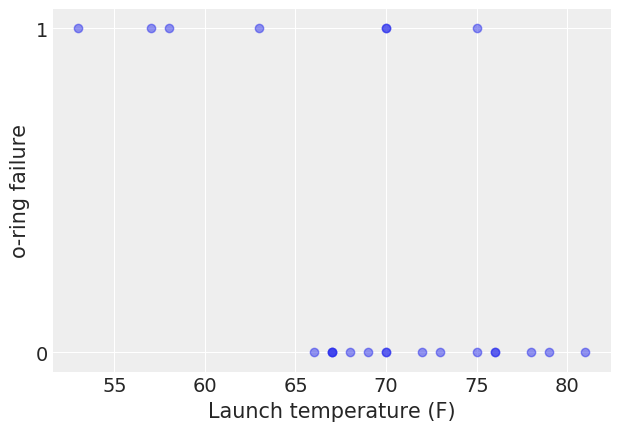

In [7]:
def plot_challenger(ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.scatter(temp_ori, failure, alpha=0.5)
    ax.set_yticks([0, 1])
    ax.set_ylabel("o-ring failure")
    ax.set_xlabel("Launch temperature (F)")

plot_challenger()

In [8]:
with pm.Model() as model:
    α = pm.Normal("α", mu=0, sd=1)
    β = pm.Normal("β", mu=0, sd=1)

    p = pm.Deterministic('p', pm.math.sigmoid(α + β * temp))
    obs = pm.Bernoulli("obs", p, observed=failure)

    trace = pm.sample(1000)

INFO (theano.gof.compilelock): Waiting for existing lock by process '4345' (I am process '4441')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/osvaldo/.theano/compiledir_Linux-5.0--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1232.78draws/s]


/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


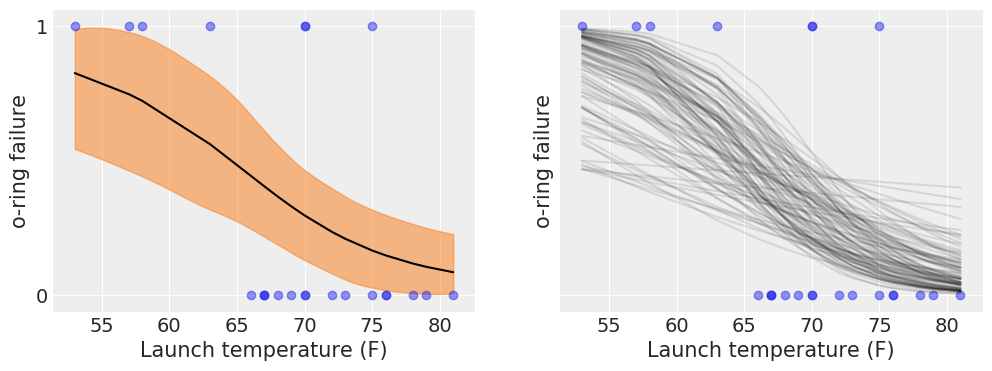

In [9]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
idx = temp_ori.argsort()
az.plot_hpd(temp_ori, trace['p'], ax=ax[0])
ax[0].plot(temp_ori[idx], trace['p'].mean(0)[idx], 'k')
plot_challenger(ax[0])

for p_pred in trace['p'][:100]:
    ax[1].plot(temp_ori[idx], p_pred[idx], 'k', alpha=0.1)
plot_challenger(ax[1])

* In a logistic regression $p$ is the probability of y=1.

* In a logistic regression the coefficient $\beta$ encodes the increase of $p$, in log-odds units, per increase of unit of $x$:

$$ \text{log-odds} = log \left(\frac {p(y = 1)} {1-p (y = 1)} \right)$$

Text(0, 0.5, 'log-odds')

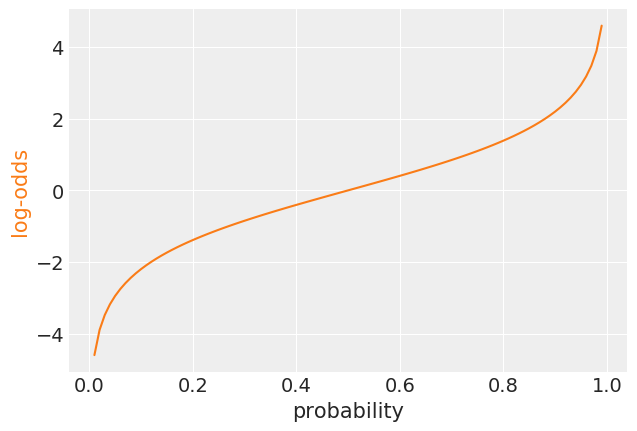

In [10]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax = plt.subplots()
ax.plot(probability, np.log(odds), 'C1')

ax.set_xlabel('probability')
ax.set_ylabel('log-odds', color='C1')

## Interpretación de los coeficientes de una regresión logística

Debemos tener cuidado al interpretar los coeficientes $\beta$ de una regresión logística. La interpretación no es tan sencilla como con los modelos lineales en el capítulo anterior. La función logística introduce una no linearidad, que debemos tener en cuenta. Si $\beta$ es positivo, aumentar $x$ aumentará $p(y = 1)$ en cierta cantidad, pero la cantidad no es una función lineal de $x$, es en cambio una función no-lineal de $x$. Podemos visualizar este hecho en la figura 4.4, en lugar de una línea con una pendiente constante, tenemos una línea en forma de S con una pendiente que cambia en función de $x$. Un poco de álgebra nos puede dar una idea de cuánto cambia $p(y=1)$ con $\beta$:

El modelo logístico básico es:

$$\theta = logistic (\alpha + X \beta) \tag{4.11} $$

El inverso de la logística es la función logit, que es:

$$ logit(z) = log \left (\frac{z}{1-z} \right) \tag{4.12}$$

Por lo tanto, si tomamos la primera ecuación en esta sección y aplicamos la función logit a ambos términos, obtenemos:

$$ logit(\theta) = \alpha + X \beta \tag{4.13}$$

O equivalente:

$$ log \left (\frac{\theta} {1-\theta} \right) = \alpha + X \beta \tag {4.14}$$

Recuerden que $\theta$ en nuestro modelo era la probabilidad de $y = 1 $, por lo tanto:

$$ log \left(\frac {p(y = 1)} {1-p (y = 1)} \right) = \alpha + X \beta \tag {4.15} $$

La cantidad $$\frac{p (y = 1)} {1-p (y = 1)}$$ se conoce como **odds**. Los odds a favor se definen como la relación entre la probabilidad de éxito y la probabilidad de no éxito. Mientras que la probabilidad de obtener 2 tirando un dado es 1/6, los odds para el mismo evento son $\frac{1/6}{5/6} \simeq 0.2$ o dicho de otra forma 1 evento favorable frente a 5 eventos desfavorables. Los odds suelen ser utilizadas por los jugadores principalmente porque proporcionan una herramienta más intuitiva que las probabilidades _en bruto_ cuando se piensa en la forma correcta de apostar.

> En una regresión logística, el coeficiente $\beta$ codifica el aumento en unidades de log-odds por unidad de aumento de la variable $x$.

La transformación de probabilidad a odds es una transformación monotónica, lo que significa que las probabilidades aumentan a medida que aumenta la probabilidad. Mientras que las probabilidades están restringidas al intervalo $[0, 1]$, los odds viven en el intervalo $[0, \infty]$. El logaritmo es otra transformación monótonica y los log-odds están en el intervalo $[-\infty, \infty]$. La figura 4.6 muestra cómo la probabilidad está relacionada con los odds y los log-odds.

In [11]:
logodds = 1
f'a log-odds {logodds} is equivalent to a probability of {logistic(logodds):.3f}'

'a log-odds 1 is equivalent to a probability of 0.731'

What the priors imply for a logistic regression?

In [12]:
with pm.Model() as model:
    α = pm.Normal("α", mu=0, sd=1)
    β = pm.Normal("β", mu=0, sd=1)

    p = pm.Deterministic('p', pm.math.sigmoid(α + β * temp))
    obs = pm.Bernoulli("obs", p, observed=failure)

    prior_predictive_sample = pm.sample_prior_predictive(1000)

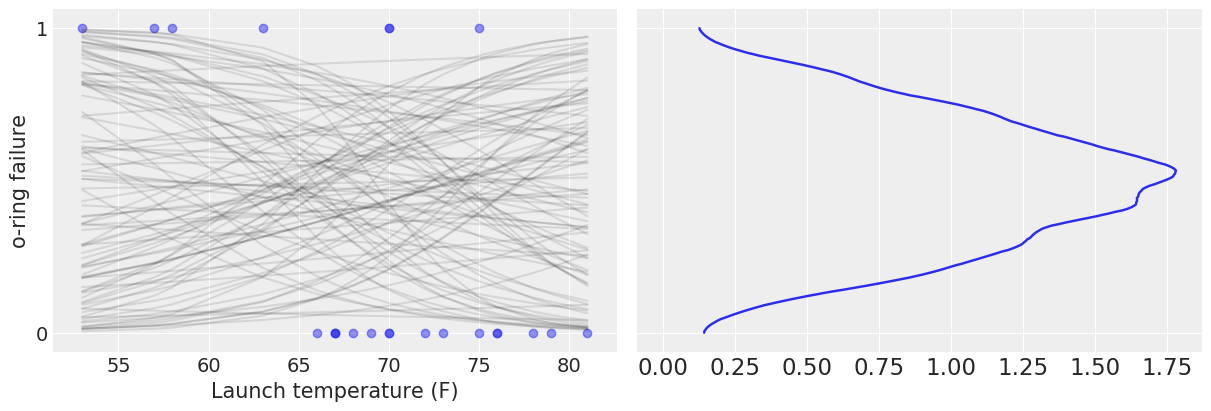

In [13]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)

for p_pred in prior_predictive_sample['p'][:100]:
    ax[0].plot(temp_ori[idx], p_pred[idx], 'k', alpha=0.1)
plot_challenger(ax[0])

az.plot_kde(prior_predictive_sample['obs'].mean(1), rug_kwargs={'alpha':0.01}, ax=ax[1], rotated=True);